In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import scikit-learn

In [2]:
tickers = [
    'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT',
    'AMZN', 'AVGO', 'AXP', 'BA', 'BAC', 'BK', 'BKNG', 'BLK', 'BMY',
    'BRK-B', 'C', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST',
    'CRM', 'CSCO', 'CVS', 'CVX', 'DE', 'DHR', 'DIS', 'DUK', 'EMR',
    'FDX', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD',
    'HON', 'IBM', 'INTC', 'INTU', 'ISRG', 'JNJ', 'JPM', 'KO', 'LIN',
    'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'MET', 'META',
    'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NOW',
    'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PLTR', 'PM', 'PYPL', 'QCOM',
    'RTX', 'SBUX', 'SCHW', 'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS',
    'TSLA', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC',
    'WMT', 'XOM'
]
start_date = '2005-01-01'
end_date = '2025-04-10'

data = yf.download(tickers, start=start_date, end=end_date, threads=True)

C:\Users\bugat\AppData\Local\Temp\ipykernel_5008\3236913702.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, threads=True)
[*********************100%***********************]  101 of 101 completed


In [3]:
close_prices = data['Close']

In [4]:
returns = np.log(close_prices / close_prices.shift(1)).dropna()

In [ ]:
from scipy.stats import linregress,skew

#rolling 20d momentum
momentum = returns.rolling(window=20).sum()

#rolling 60d volatility
volatility = returns.rolling(window=60).std()

#rolling skewness over 60 days
skewness = returns.rolling(window=60).apply(lambda x: skew(x), raw=False)

#rolling beta to mkt (equal-weighted index)
market_returns = returns.mean(axis=1)
beta = pd.DataFrame(index=returns.index, columns=returns.columns)

#rolling beta using 60-day window
window = 60
for t in range(window,len(returns)):
    window_returns = returns.iloc[t-window:t]
    market_window = market_returns.iloc[t-window:t]
    for col in returns.columns:
        slope, _,_,_,_ = linregress(market_window, window_returns[col])
        beta.iloc[t,returns.columns.get_loc(col)] = slope

features = pd.concat(
    [momentum.add_suffix('_momentum'),
     volatility.add_suffix('_volatility'),
     skewness.add_suffix('_skewness'),
     beta.add_suffix('_beta')],
    axis=1
).dropna()

In [6]:
feature_list = ['momentum','volatility','skewness','beta']
data_list = []

for ticker in returns.columns:
    df = pd.DataFrame({
        'Ticker': ticker,
        'Momentum': features[f'{ticker}_momentum'],
        'Volatility': features[f'{ticker}_volatility'],
        'Skewness': features[f'{ticker}_skewness'],
        'Beta': features[f'{ticker}_beta'],
    })
    data_list.append(df)

features_long = pd.concat(data_list)

In [7]:
future_returns = returns.shift(-1)

future_returns_long = future_returns.stack().reset_index()
future_returns_long.columns = ['Date','Ticker','Target']

dataset = pd.merge(features_long,future_returns_long, on=['Date','Ticker']).dropna()

In [8]:
dataset['Momentum_x_Volatility'] = dataset['Momentum'] * dataset['Volatility']
dataset['Beta_squared'] = dataset['Beta'] ** 2

returns = returns.apply(pd.to_numeric, errors='coerce')
reversal_raw = -returns.rolling(5).sum()
reversal = reversal_raw.stack().reset_index()
reversal.columns = ['Date', 'Ticker', 'Reversal']
dataset = pd.merge(dataset, reversal, on=['Date', 'Ticker'], how='inner')

In [9]:
def zscore_cross_sectional(df, feature_cols):
    return df.groupby('Date')[feature_cols].transform(lambda x: (x - x.mean()) / x.std())

features = ['Momentum','Volatility','Skewness','Beta','Target','Momentum_x_Volatility','Beta_squared','Reversal']
dataset[features] = zscore_cross_sectional(dataset, features)

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dataset = dataset.sort_values(['Date','Ticker']).reset_index(drop=True)

X = dataset[['Momentum','Volatility','Skewness','Beta','Momentum_x_Volatility','Beta_squared','Reversal']]
Y = dataset['Target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
split_n = int(0.8*len(X_scaled))
X_train, X_test = X_scaled[:split_n],X_scaled[split_n:]
Y_train, Y_test = Y[:split_n],Y[split_n:]

dates_test = dataset['Date'].iloc[split_n:].values
tickers_test = dataset['Ticker'].iloc[split_n:].values

In [12]:
from scipy.stats import spearmanr

for i in range(5):

    model = xgb.XGBRegressor(n_estimators=120, max_depth=3, learning_rate=0.1, subsample=0.8,random_state=i)
    model.fit(X_train, Y_train)

    y_pred = model.predict(X_test)

    results = pd.DataFrame({
        'Date': dates_test,
        'Ticker': tickers_test,
        'Predicted': y_pred,
        'Actual': Y_test.values
    })

    ics = []
    for date, group in results.groupby('Date'):
        if len(group) > 3:
            ic = spearmanr(group['Predicted'].rank(), group['Actual']).correlation
            ics.append(ic)

    ics = pd.Series(ics)
    print(i,'--')
    print(f"IC Mean: {ics.mean():.4f}") # >0.05
    print(f"IC Std: {ics.std():.4f}") #volatility of IC, aim for 0.05-0.15
    print(f"IC Sharpe (mean/std): {ics.mean()/ics.std():.4f}") #risk adjusted IC>0.5
    print('\n\n')

0 --
IC Mean: -0.0001
IC Std: 0.1230
IC Sharpe (mean/std): -0.0008



1 --
IC Mean: 0.0009
IC Std: 0.1267
IC Sharpe (mean/std): 0.0072



2 --
IC Mean: 0.0070
IC Std: 0.1230
IC Sharpe (mean/std): 0.0568



3 --
IC Mean: 0.0060
IC Std: 0.1220
IC Sharpe (mean/std): 0.0495



4 --
IC Mean: 0.0051
IC Std: 0.1230
IC Sharpe (mean/std): 0.0416





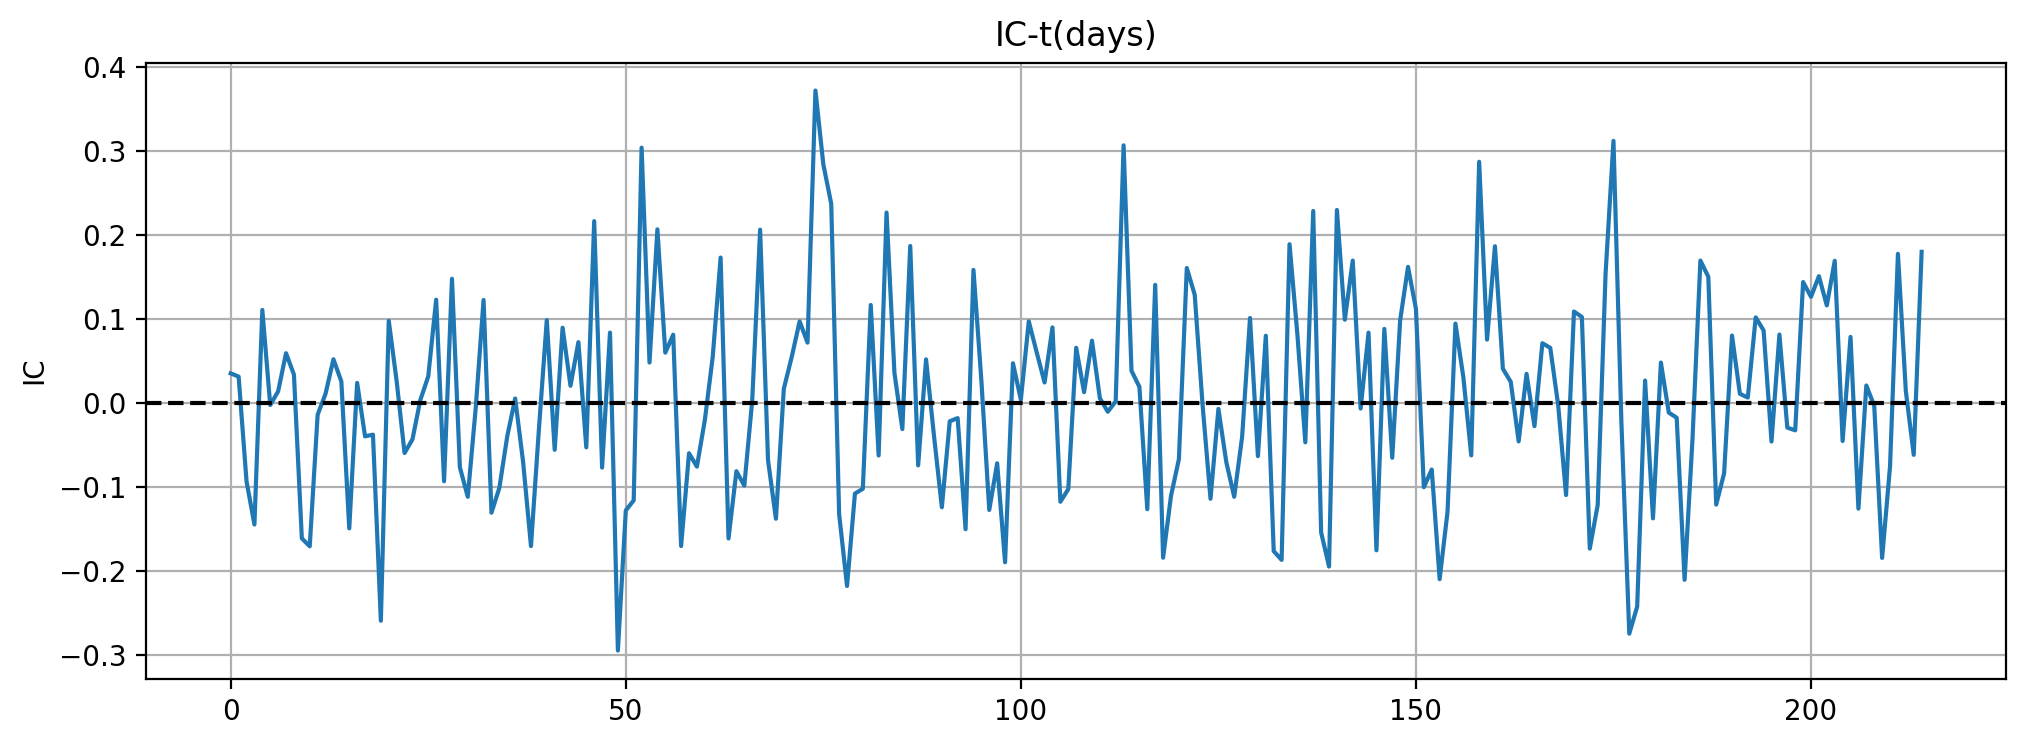

In [13]:
plt.figure(figsize=(12, 4))
ics.plot()
plt.axhline(0, color='black', linestyle='--')
plt.title('IC-t(days)')
plt.ylabel('IC')
plt.grid()
plt.show()